# Polynomial Model as PyTorch Module 
* NOTE: graphviz must be installed for visualizations
* In linux you can run: sudo apt install graphviz

In [1]:
# !pip install torchviz
# !pip install hiddenlayer
# !sudo apt install graphviz

If you getting crash on `plt.plot()` it is because of `Disposing session as kernel process died ExitCode: 3, Reason: OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.` error. 

To fix this issue:

In [ ]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchviz import make_dot, make_dot_from_trace
import hiddenlayer as hl

import matplotlib.pyplot as plt
import math
from datetime import datetime

torch.manual_seed(1234)

# Generate Data

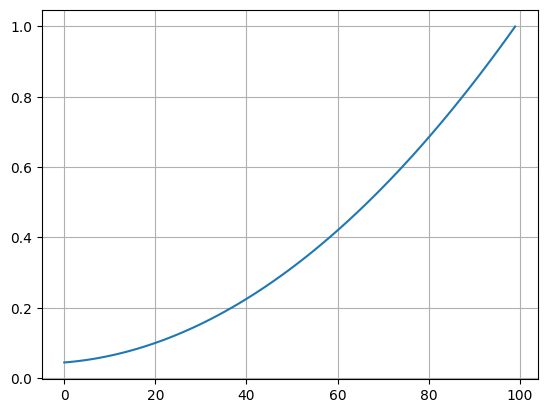

In [3]:
# Create Tensors to hold input and outputs.
x = torch.linspace(0.1, 10, 100)
y = (x**2) + x + 5
#y = torch.sin(2*torch.pi*x*0.1)
#y =  (x**3) + x ** 2 + x - 10

y /= y.abs().max()
plt.plot(y, label='original')
plt.grid()

# Polynomial Model
* We are using *nn.Parameters()* for trainable parameters
* You can think nn.Parameters() are just **tensors with requires_grad=True**
* Other PyTorch modules use nn.Parameters() to build common deep learning blocks
* See: nn.Linear, nn.Conv2d, nn.GRU, nn.LSTM, nn.Transformer

In [4]:
class PolynomialModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize model parameters
        self.w0 = nn.Parameter(torch.randn(1)) # torch.tensor(torch.randn(1), requires_grad=True)
        self.w1 = nn.Parameter(torch.randn(1))
        self.w2 = nn.Parameter(torch.randn(1))
        
    # Forward pass
    # YOU MUST IMPLEMENT THIS FUNCTION
    def forward(self, x):
        return self.w0 + self.w1 * x + self.w2 * (x ** 2)
        # Another model
        #return self.w0 + self.w1 * x + self.w2 * (x ** 3)

    # Optional function for printing polynomial
    def string(self):
        return f'y = {self.w0.item():.4f} + {self.w1.item():.4f} x + {self.w2.item():.4f} x^2'

### Intialize Model

`.string()` function prints the mathematical function itself in string format. 

In [5]:
# Construct our model by instantiating the class defined above
model = PolynomialModel()
print(model.string())

y = 0.0461 + 0.4024 x + -1.0115 x^2


## Print Model Parameters
parameters are the weights of the `PolynomialModel()`. The value of the weights also visible in a user-friendly way via `.string()` function.

In [6]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([0.0461], requires_grad=True)
Parameter containing:
tensor([0.4024], requires_grad=True)
Parameter containing:
tensor([-1.0115], requires_grad=True)


## Pretty Print with Names

In [7]:
for n, p in model.named_parameters():
    print(f'name: {n} and parameter data: {p.data}')

name: w0 and parameter data: tensor([0.0461])
name: w1 and parameter data: tensor([0.4024])
name: w2 and parameter data: tensor([-1.0115])


# Define Loss and Optimizer
### Mean Squarred Error
* See all loss functions: [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

#### Common Use: 

- `BCELoss()` for Binary Classification Scenarios and `CrossEntropyLoss()` for Multi-Label Classification Scenarios are used in most of the Text or Image Classification tutorials. 

- Do not forget the loss function is actually case-specific funtions. You can also create your custom loss functions.

In [8]:
# In PyTorch, loss functions called are criterion 
# This is just a jargon, you can call it whatever you want
criterion = torch.nn.MSELoss()

### Stochastic Gradient Descent Optimizer
* **Also check out: Learning Rate Scheduling**
* See all optimizers & schedulers: https://pytorch.org/docs/stable/optim.html

In [9]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) # 0.02 SGD, 0.001 Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.02 SGD, 0.001 Adam

# Training Loop

In [10]:
num_epochs = 15_000

start_time = datetime.now()

for e in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if e % 1000 == 0:
        print(f'Epoch: {e} loss: {loss.item():.4f}')

    # Zero gradients, perform a backward pass, and update the weights.
    # In PyTorch, gradients are accumulated, you need to reset gradients in each loop
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
    # Update gradients
    optimizer.step()

delta_time = datetime.now() - start_time
#print(f'Training took: {delta_time.hour}:{delta_time.minute}:{delta_time.second}')
print(f'Training took: {delta_time}')

Epoch: 0 loss: 1934.3074
Epoch: 1000 loss: 54.7718
Epoch: 2000 loss: 54.7698
Epoch: 3000 loss: 54.7690
Epoch: 4000 loss: 54.7689
Epoch: 5000 loss: 54.7683
Epoch: 6000 loss: 54.7679
Epoch: 7000 loss: 54.7667
Epoch: 8000 loss: 54.7667
Epoch: 9000 loss: 54.7663
Epoch: 10000 loss: 54.7662
Epoch: 11000 loss: 54.7659
Epoch: 12000 loss: 54.7662
Epoch: 13000 loss: 54.7662
Epoch: 14000 loss: 54.7662
Training took: 0:00:07.798642


# Results Comparsion

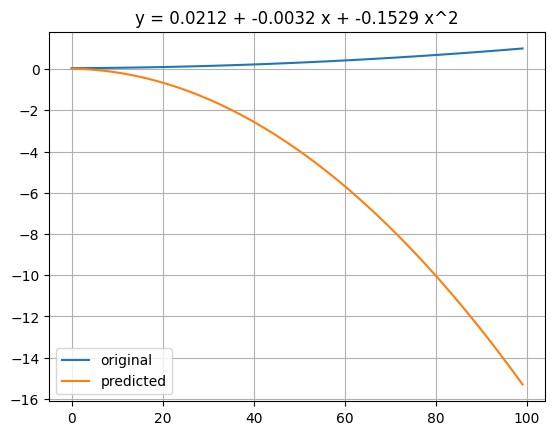

In [11]:
plt.plot(y, label='original')
plt.plot(model(x).detach().numpy(), label='predicted')
plt.title(model.string())
plt.legend()
plt.grid()

# Backprop Visualization
### NOTE: You need to install graphviz to your computer!

### with Hiddenlayer

In [ ]:
hl.build_graph(model, torch.zeros_like(y).unsqueeze(0))

### with Torchviz

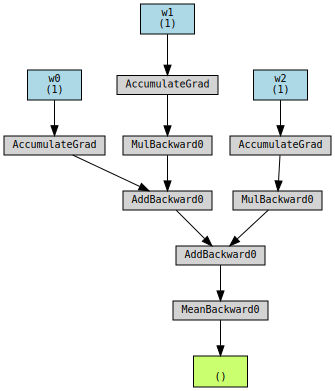

In [12]:
make_dot(model(y).mean(), params=dict(list(model.named_parameters())))
#make_dot(model(y).mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)